# Introduction
    1. Training data and test data have been removed the exception data
    2. The product ID in the total csv files have different types: int & str. It needs to tranform 
       the type of int to the type of str.

# 1. Load data

### 1.1 Load training data

In [32]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from tqdm import tqdm_notebook

In [2]:
df_train = pd.read_csv('training-set.csv', header=None)
df_train.columns = ['FileID', 'Label']
df_train.head()

,FileID,Label
0,0000e2398b12121a85166fed5fe2a3da,0
1,0001fe8dce14ce099aa6ca8ea5026ea7,0
2,00027f50019000accc492e5684efc818,0
3,00028c9da3573ec50db74b44310ae507,0
4,0003dc8130969abe688cadf5f14ea19f,0


In [3]:
print('len(training): ', len(df_train))

len(training):  52518


### 1.2 Load testing data

In [51]:
df_test = pd.read_csv('testing-set.csv')
# df_test.columns = ['FileID', 'Label']
df_test.head()

,FileID,Label
0,00008c73ee43c15b16c26b26398c1577,0.012381
1,0002ded3a0b54f2ffdab0ca77a5ce2b6,0.514261
2,00050a9df8e13f6ab5a3d3b3e2fc6a86,0.003120
3,000b1aa62b95e448784b8b341de46c64,0.016599
4,000d9f96b5eddf04a3b7a37cb95d0a00,0.025591


In [119]:
print('len(testing): ', len(df_test))

len(testing):  29376


### 1.3 Load query_log data

In [4]:
query_log_list = os.listdir('query_log')
# In my computer there is a file named ".ipynb_checkpoints" and it needs to remove it
query_log_list.remove('.ipynb_checkpoints')
# Sort by the date
query_log_list.sort()
query_log_list[:5]

['0301.csv', '0302.csv', '0303.csv', '0304.csv', '0305.csv']

In [5]:
path = '/data/examples/trend/data/query_log/'
df_query_log = pd.DataFrame()
for i in tqdm_notebook(range(len(query_log_list))):
    # get the date and store it in the column 4 of df
    day = int(query_log_list[i].split('.')[0])
    df = pd.read_csv(path+query_log_list[i], encoding='utf-8', header=None)
    df[4] = day
    # record the times
    df[5] = 1
    df_query_log = pd.concat([df_query_log, df], ignore_index=True)

HBox(children=(IntProgress(value=0, max=92), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_query_log.columns = ['FileID', 'CustomerID', 'QueryTs', 'ProductID', 'Day', 'Times']
df_query_log.head()

,FileID,CustomerID,QueryTs,ProductID,Day,Times
0,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326402,c105a0,301,1
1,29962f9102502ee76bb3cddb8cf8c9ad,597df153a25e8e548cbe35f6e4da9cbb,1488326403,c105a0,301,1
2,fa3fa642378b9d98c0e2770611b92eb3,1db24b8cc0a7ce59634629e7f292520f,1488326405,c105a0,301,1
3,48f90ea1af2c04677c6890db392ca088,5ca6dd0b8863069ab1efe014de82cecf,1488326411,c76d58,301,1
4,d0ff310c25e3bd7ae919d34dc38fb0de,5ca6dd0b8863069ab1efe014de82cecf,1488326411,c76d58,301,1


In [7]:
# Change the type of int to the type of str
df_query_log['ProductID'] = df_query_log['ProductID'].astype('str')

In [9]:
# df_0301 = pd.read_csv('query_log/0301.csv', header=None)
# df_0301.columns = ['FileID', 'CustomerID', 'QueryTs', 'ProductID']
# df_0301.head()

,FileID,CustomerID,QueryTs,ProductID
0,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326402,c105a0
1,29962f9102502ee76bb3cddb8cf8c9ad,597df153a25e8e548cbe35f6e4da9cbb,1488326403,c105a0
2,fa3fa642378b9d98c0e2770611b92eb3,1db24b8cc0a7ce59634629e7f292520f,1488326405,c105a0
3,48f90ea1af2c04677c6890db392ca088,5ca6dd0b8863069ab1efe014de82cecf,1488326411,c76d58
4,d0ff310c25e3bd7ae919d34dc38fb0de,5ca6dd0b8863069ab1efe014de82cecf,1488326411,c76d58


### 1.4 Start time & end time 
    Start time & end time which can be got from the first data in 0301.csv & the last data in 
    0531.csv

In [8]:
start_time = 1488326402
end_time   = 1496275198

# 2. Observe data

### 2.1 Very Imbalance

In [9]:
print('In training data:')
print('#0: ', sum(df_train['Label']==0), '(%s)' % str(sum(df_train['Label']==0)/52518))
print('#1:  ', sum(df_train['Label']==1), '(%s)' % str(sum(df_train['Label']==1)/52518))

In training data:
#0:  46878 (0.8926082486)
#1:   5640 (0.1073917514)


### 2.2 FileID vs Day

In [10]:
df_FileID_Day = df_query_log.pivot_table(values='Times', index=['FileID'], columns='Day', aggfunc='sum')
df_FileID_Day = df_FileID_Day.fillna(0)
df_FileID_Day.head()

Day,301,302,303,304,305,306,307,308,309,310,...,522,523,524,525,526,527,528,529,530,531
FileID,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000e2398b12121a85166fed5fe2a3da,0.0,0.0,0.0,43.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001fe8dce14ce099aa6ca8ea5026ea7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00027f50019000accc492e5684efc818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00028c9da3573ec50db74b44310ae507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_FileID_Day_features = pd.DataFrame(columns=['Total(Day)', 'Max(Day)', 'Min(Day)', 'Mean(Day)', 'Mean(Nonzero Day)', 'Std(Day)'])
df_FileID_Day_features['Total(Day)'] = df_FileID_Day.sum(axis=1)

#### Every files have been opened at least once. So we can find the max, min, mean, std in 0301 ~ 0531, and the mean in the days when the files have been opened.

In [12]:
(df_FileID_Day_features['Total(Day)'] == 0).sum()

0

#### There are 50 files are only opened once.

In [13]:
(df_FileID_Day_features['Total(Day)'] == 1).sum()

50

In [14]:
df_FileID_Day_features['Max(Day)'] = df_FileID_Day.max(axis=1)
df_FileID_Day_features['Min(Day)'] = df_FileID_Day.min(axis=1)
df_FileID_Day_features['Mean(Day)'] = df_FileID_Day.mean(axis=1)
df_FileID_Day_features['Mean(Nonzero Day)'] = df_FileID_Day_features['Total(Day)'] / (df_FileID_Day > 0).sum(axis=1)
df_FileID_Day_features['Std(Day)'] = df_FileID_Day.std(axis=1)
# df_FileID_Day_features['Std(Nonzero Day)'] = (df_FileID_Day[df_FileID_Day.sum()]).std(axis=1)
df_FileID_Day_features.head()

,Total(Day),Max(Day),Min(Day),Mean(Day),Mean(Nonzero Day),Std(Day)
FileID,,,,,,
00008c73ee43c15b16c26b26398c1577,134.0,50.0,0.0,1.456522,22.333333,6.625646
0000e2398b12121a85166fed5fe2a3da,47.0,43.0,0.0,0.510870,15.666667,4.490514
0001fe8dce14ce099aa6ca8ea5026ea7,234.0,66.0,0.0,2.543478,39.000000,10.848014
00027f50019000accc492e5684efc818,378.0,253.0,0.0,4.108696,75.600000,27.685223
00028c9da3573ec50db74b44310ae507,368.0,339.0,0.0,4.000000,61.333333,35.337307


#### df_FileID_Day_features has no NaN

In [15]:
np.isnan(df_FileID_Day_features).sum(axis=0)

Total(Day)           0
Max(Day)             0
Min(Day)             0
Mean(Day)            0
Mean(Nonzero Day)    0
Std(Day)             0
dtype: int64

### 2.4 FileID vs ProductID

In [16]:
df_FileID_ProductID = df_query_log.pivot_table(values='Times', index=['FileID'], columns='ProductID', aggfunc='sum')
df_FileID_ProductID = df_FileID_ProductID.fillna(0)
df_FileID_ProductID.head()

ProductID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,...,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f
FileID,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0
0000e2398b12121a85166fed5fe2a3da,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001fe8dce14ce099aa6ca8ea5026ea7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0
00027f50019000accc492e5684efc818,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
00028c9da3573ec50db74b44310ae507,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_FileID_ProductID_features = pd.DataFrame(columns=['Total(ProductID)', 'Max(ProductID)', 'Min(ProductID)', 'Mean(ProductID)', 'Std(ProductID)'])
df_FileID_ProductID_features['Total(ProductID)'] = df_FileID_ProductID.sum(axis=1)

#### Every files have been opened at least once. So we can find the max, min, mean, std about all ProductID.

In [18]:
(df_FileID_ProductID_features['Total(ProductID)'] == 0).sum()

0

In [19]:
df_FileID_ProductID_features['Max(ProductID)'] = df_FileID_ProductID.max(axis=1)
df_FileID_ProductID_features['Min(ProductID)'] = df_FileID_ProductID.min(axis=1)
df_FileID_ProductID_features['Mean(ProductID)'] = df_FileID_ProductID.mean(axis=1)
df_FileID_ProductID_features['Std(ProductID)'] = df_FileID_ProductID.std(axis=1)
df_FileID_ProductID_features.head()

,Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID)
FileID,,,,,
00008c73ee43c15b16c26b26398c1577,134.0,83.0,0.0,4.620690,15.951744
0000e2398b12121a85166fed5fe2a3da,47.0,38.0,0.0,1.620690,7.193319
0001fe8dce14ce099aa6ca8ea5026ea7,234.0,141.0,0.0,8.068966,28.011389
00027f50019000accc492e5684efc818,378.0,146.0,0.0,13.034483,36.908654
00028c9da3573ec50db74b44310ae507,368.0,290.0,0.0,12.689655,54.644372


#### df_FileID_ProductID_features has no NaN

In [20]:
np.isnan(df_FileID_ProductID_features).sum(axis=0)

Total(ProductID)    0
Max(ProductID)      0
Min(ProductID)      0
Mean(ProductID)     0
Std(ProductID)      0
dtype: int64

### 2.5 Mean & std of time interval

In [21]:
def time_interval_mean(list):
    if len(list) == 1:
        # There are 50 files were opened once.
        # If a file was only oppened once, we can't get the time interval. Assign the total seconds to it.
        return end_time - start_time
    return np.mean(np.diff(list))

In [22]:
def time_interval_std(list):
    if len(list) == 1:
        # If a file was only oppened once, we can't get the time interval. Suppose the time interval
        # is the total seconds, and these files were opened twice in that time interval, so we can 
        # assign the 
        # std = [(start_time - mean)^2 + (end_time - mean)^2] / (2 - 1) = (start_time - end_time)^2 / 2
        # to it
        return (start_time - end_time)**2/2
    return np.std(np.diff(list))

#### Calculate the time interval 

In [23]:
df_FileID_time_interval = df_query_log.groupby('FileID')['QueryTs'].aggregate([time_interval_mean, time_interval_std])
df_FileID_time_interval.head()

,time_interval_mean,time_interval_std
FileID,,
00008c73ee43c15b16c26b26398c1577,3655.233083,15011.807565
0000e2398b12121a85166fed5fe2a3da,8116.000000,43395.408067
0001fe8dce14ce099aa6ca8ea5026ea7,1965.403433,11515.073217
00027f50019000accc492e5684efc818,828.177719,10732.170012
00028c9da3573ec50db74b44310ae507,1319.098093,9324.414712


#### df_FileID_time_interval has no NaN

In [24]:
np.isnan(df_FileID_time_interval).sum(axis=0)

time_interval_mean    0
time_interval_std     0
dtype: int64

# 3. Combine all features

In [25]:
df_features = pd.concat([df_FileID_ProductID, df_FileID_Day_features, df_FileID_ProductID_features, df_FileID_time_interval],axis=1)
df_features.head()

,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,...,Mean(Day),Mean(Nonzero Day),Std(Day),Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID),time_interval_mean,time_interval_std
FileID,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,...,1.456522,22.333333,6.625646,134.0,83.0,0.0,4.620690,15.951744,3655.233083,15011.807565
0000e2398b12121a85166fed5fe2a3da,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.510870,15.666667,4.490514,47.0,38.0,0.0,1.620690,7.193319,8116.000000,43395.408067
0001fe8dce14ce099aa6ca8ea5026ea7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.543478,39.000000,10.848014,234.0,141.0,0.0,8.068966,28.011389,1965.403433,11515.073217
00027f50019000accc492e5684efc818,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,...,4.108696,75.600000,27.685223,378.0,146.0,0.0,13.034483,36.908654,828.177719,10732.170012
00028c9da3573ec50db74b44310ae507,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,...,4.000000,61.333333,35.337307,368.0,290.0,0.0,12.689655,54.644372,1319.098093,9324.414712


#### df_features has the FileID as its index. Need to transform the FileID into a column.

In [26]:
df_features = df_features.reset_index()
df_features.head()

,FileID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,...,Mean(Day),Mean(Nonzero Day),Std(Day),Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID),time_interval_mean,time_interval_std
0,00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.456522,22.333333,6.625646,134.0,83.0,0.0,4.620690,15.951744,3655.233083,15011.807565
1,0000e2398b12121a85166fed5fe2a3da,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.510870,15.666667,4.490514,47.0,38.0,0.0,1.620690,7.193319,8116.000000,43395.408067
2,0001fe8dce14ce099aa6ca8ea5026ea7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.543478,39.000000,10.848014,234.0,141.0,0.0,8.068966,28.011389,1965.403433,11515.073217
3,00027f50019000accc492e5684efc818,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.108696,75.600000,27.685223,378.0,146.0,0.0,13.034483,36.908654,828.177719,10732.170012
4,00028c9da3573ec50db74b44310ae507,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.000000,61.333333,35.337307,368.0,290.0,0.0,12.689655,54.644372,1319.098093,9324.414712


#### Merge the training data and all features

In [27]:
df_train_final = pd.merge(df_train, df_features, on=['FileID'], how='left')
df_train_final.head()

,FileID,Label,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,...,Mean(Day),Mean(Nonzero Day),Std(Day),Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID),time_interval_mean,time_interval_std
0,0000e2398b12121a85166fed5fe2a3da,0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.510870,15.666667,4.490514,47.0,38.0,0.0,1.620690,7.193319,8116.000000,43395.408067
1,0001fe8dce14ce099aa6ca8ea5026ea7,0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.543478,39.000000,10.848014,234.0,141.0,0.0,8.068966,28.011389,1965.403433,11515.073217
2,00027f50019000accc492e5684efc818,0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.108696,75.600000,27.685223,378.0,146.0,0.0,13.034483,36.908654,828.177719,10732.170012
3,00028c9da3573ec50db74b44310ae507,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.000000,61.333333,35.337307,368.0,290.0,0.0,12.689655,54.644372,1319.098093,9324.414712
4,0003dc8130969abe688cadf5f14ea19f,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.554348,39.166667,14.365224,235.0,172.0,0.0,8.103448,32.478944,1967.081197,14497.223003


# Split data

#### Because #0 >> #1, it needs to split the training data by 

In [28]:
df_nonvirus = df_train_final[df_train_final['Label']==0]
df_virus    = df_train_final[df_train_final['Label']==1]

In [29]:
print(len(df_nonvirus))
print(len(df_virus))

46878
5640


In [30]:
df_virus.head()

,FileID,Label,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,...,Mean(Day),Mean(Nonzero Day),Std(Day),Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID),time_interval_mean,time_interval_std
6,0005e4c0263f52453438ddd0d55aef82,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.000000,61.333333,17.462676,368.0,161.0,0.0,12.689655,39.592661,1343.449591,7544.569808
17,00117b31bd107c43123c8a0180dc036c,1,0.0,17.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.836957,28.166667,12.840764,169.0,111.0,0.0,5.827586,21.389365,2341.898810,15909.632457
23,001abb71230ddab7ff7016ccfac80d16,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.076087,77.833333,37.152857,467.0,235.0,0.0,16.103448,46.134388,1065.396996,10496.769980
28,0023276a212ce8efa247fc1bca44b853,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.271739,8.333333,2.204407,25.0,14.0,0.0,0.862069,2.850115,12863.958333,57689.123669
35,002d78cefc2397e89c416fb1938024d8,1,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,...,0.336957,7.750000,2.154868,31.0,19.0,0.0,1.068966,3.863113,10520.633333,32142.635006


In [31]:
X_nonvirus = df_nonvirus.iloc[:, 2:]
y_nonvirus = df_nonvirus.iloc[:, 1]
X_virus = df_virus.iloc[:,2:]
y_virus = df_virus.iloc[:,1]
print(X_nonvirus.shape)
print(y_nonvirus.shape)
print(X_virus.shape)
print(y_virus.shape)

(46878, 42)
(46878,)
(5640, 42)
(5640,)


In [39]:
X_nonvirus_train, X_nonvirus_valid, y_nonvirus_train, y_nonvirus_valid = train_test_split(X_nonvirus, y_nonvirus, test_size=0.2, shuffle=True)
X_virus_train, X_virus_valid, y_virus_train, y_virus_valid = train_test_split(X_virus, y_virus, test_size=0.2, shuffle=True)

In [40]:
X_train = np.vstack([X_nonvirus_train, X_virus_train])
y_train = np.hstack([y_nonvirus_train, y_virus_train])
X_valid = np.vstack([X_nonvirus_valid, X_virus_valid])
y_valid = np.hstack([y_nonvirus_valid, y_virus_valid])

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(42014, 42)
(42014,)
(10504, 42)
(10504,)


# Model

In [42]:
eval_set = [(X_valid, y_valid)]

model = XGBClassifier(learning_rate=0.1, n_estimators=3000, max_depth=10)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.832852
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.853598
[2]	validation_0-auc:0.85658
[3]	validation_0-auc:0.861704
[4]	validation_0-auc:0.865182
[5]	validation_0-auc:0.867989
[6]	validation_0-auc:0.870218
[7]	validation_0-auc:0.872569
[8]	validation_0-auc:0.87458
[9]	validation_0-auc:0.878021
[10]	validation_0-auc:0.8804
[11]	validation_0-auc:0.880672
[12]	validation_0-auc:0.882161
[13]	validation_0-auc:0.885178
[14]	validation_0-auc:0.889516
[15]	validation_0-auc:0.889543
[16]	validation_0-auc:0.890497
[17]	validation_0-auc:0.89176
[18]	validation_0-auc:0.89221
[19]	validation_0-auc:0.892667
[20]	validation_0-auc:0.89331
[21]	validation_0-auc:0.893253
[22]	validation_0-auc:0.893514
[23]	validation_0-auc:0.894644
[24]	validation_0-auc:0.895334
[25]	validation_0-auc:0.895978
[26]	validation_0-auc:0.896546
[27]	validation_0-auc:0.897472
[28]	validation_0-auc:0.898578
[29]	validation_0-auc:0.899287
[30]	validation_0-auc:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
roc_auc_score(y_train, model.predict_proba(X_train)[:,1])

0.985866327081941

In [44]:
y_pred = model.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, y_pred)

0.91442142152591199

# Test data

In [52]:
df_test_final = pd.merge(df_test, df_features, on=['FileID'], how='left')
df_test_final.head()

,FileID,Label,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,...,Mean(Day),Mean(Nonzero Day),Std(Day),Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID),time_interval_mean,time_interval_std
0,00008c73ee43c15b16c26b26398c1577,0.012381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.456522,22.333333,6.625646,134.0,83.0,0.0,4.620690,15.951744,3655.233083,15011.807565
1,0002ded3a0b54f2ffdab0ca77a5ce2b6,0.514261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.597826,395.500000,70.422596,791.0,790.0,0.0,27.275862,146.692803,247.073418,5667.738256
2,00050a9df8e13f6ab5a3d3b3e2fc6a86,0.003120,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.706522,102.833333,28.495050,617.0,427.0,0.0,21.275862,81.644655,709.012987,9313.850901
3,000b1aa62b95e448784b8b341de46c64,0.016599,0.0,32.0,0.0,0.0,4.0,0.0,0.0,1.0,...,2.630435,48.400000,24.287073,242.0,193.0,0.0,8.344828,36.013168,1542.630705,11664.186647
4,000d9f96b5eddf04a3b7a37cb95d0a00,0.025591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.793478,12.166667,3.728530,73.0,47.0,0.0,2.517241,9.283706,6032.527778,23926.613182


In [53]:
X = df_test_final.iloc[:,2:]
X.head()

,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,...,Mean(Day),Mean(Nonzero Day),Std(Day),Total(ProductID),Max(ProductID),Min(ProductID),Mean(ProductID),Std(ProductID),time_interval_mean,time_interval_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,...,1.456522,22.333333,6.625646,134.0,83.0,0.0,4.620690,15.951744,3655.233083,15011.807565
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.597826,395.500000,70.422596,791.0,790.0,0.0,27.275862,146.692803,247.073418,5667.738256
2,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.706522,102.833333,28.495050,617.0,427.0,0.0,21.275862,81.644655,709.012987,9313.850901
3,0.0,32.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,2.630435,48.400000,24.287073,242.0,193.0,0.0,8.344828,36.013168,1542.630705,11664.186647
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.793478,12.166667,3.728530,73.0,47.0,0.0,2.517241,9.283706,6032.527778,23926.613182


In [55]:
X = np.array(X)
y_pred = model.predict_proba(X)
y_pred[:5]

array([[ 0.99249595,  0.00750404],
       [ 0.42940098,  0.57059902],
       [ 0.99873751,  0.00126247],
       [ 0.99313211,  0.00686791],
       [ 0.98568195,  0.01431803]], dtype=float32)

In [56]:
df_test['Label'] = y_pred[:,1]
df_test.head()

,FileID,Label
0,00008c73ee43c15b16c26b26398c1577,0.007504
1,0002ded3a0b54f2ffdab0ca77a5ce2b6,0.570599
2,00050a9df8e13f6ab5a3d3b3e2fc6a86,0.001262
3,000b1aa62b95e448784b8b341de46c64,0.006868
4,000d9f96b5eddf04a3b7a37cb95d0a00,0.014318


In [57]:
df_test.to_csv('testing-set.csv', index=False)

# Functions

In [21]:
def time_hist(fileID, delta_time, df):
    df_time = df[df.iloc[:,0]==fileID][['QueryTs']]
    start_time = int(df_time.iloc[0,0])
    end_time   = int(df_time.iloc[-1,0])
    bins = [x for x in range(start_time, end_time, delta_time)]
    plt.hist(df_time.iloc[:,0], bins=bins)
#     plt.xticks(list(np.array(bins) - start_time))
    plt.title('FileID: '+fileID)

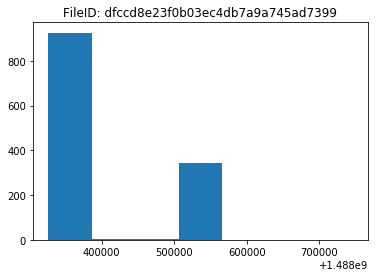

In [22]:
time_hist('dfccd8e23f0b03ec4db7a9a745ad7399', 60*1000, df_query_log)

In [52]:
def time_list(fileID, customerID, productID, df):
    df_fileID = df.loc[(df['FileID']==fileID) & (df['CustomerID']==customerID) & (df['ProductID']==productID)]['QueryTs']
    
    result = np.zeros(end_time-start_time+1)
    for j in tqdm_notebook(range(len(df_fileID))):
        result[df_fileID.iloc[j] - start_time] = 1
        
    return result

In [53]:
fileID = 'dfccd8e23f0b03ec4db7a9a745ad7399'
customerID = '64573086fcfee53e8fa6d8f1f44101bb'
productID = 'c105a0'
output = time_list(fileID, customerID, productID, df_query_log)

HBox(children=(IntProgress(value=0, max=922), HTML(value='')))

In [54]:
output[:20]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [58]:
def time_list(fileID, customerID, productID, df):
    start_time = 1488326402
    end_time   = 1496275198
    
    df_fileID = df.loc[(df.iloc[:,0]==fileID) & (df.iloc[:,1]==customerID) & (df.iloc[:,3]==productID)]['QueryTs']
    
    result = np.zeros(end_time-start_time+1)
    for j in tqdm_notebook(range(len(df_fileID))):
        result[df_fileID.iloc[j] - start_time] = 1
        
    return result

In [88]:
fileID = 'dfccd8e23f0b03ec4db7a9a745ad7399'
df_query_log.loc[df_query_log['FileID']==fileID].head()

,FileID,CustomerID,QueryTs,ProductID
0,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326402,c105a0
5,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326412,c105a0
23,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326421,c105a0
37,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326431,c105a0
39,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326441,c105a0
43,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326451,c105a0
50,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326461,c105a0
53,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326472,c105a0
62,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326482,c105a0
65,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326491,c105a0


HBox(children=(IntProgress(value=0, max=922), HTML(value='')))

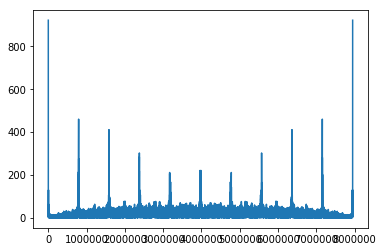

In [90]:
# label is 0 - case 1

fileID = 'dfccd8e23f0b03ec4db7a9a745ad7399'
customerID = '64573086fcfee53e8fa6d8f1f44101bb'
productID = 'c105a0'
output = time_list(fileID, customerID, productID, df_query_log)

from numpy.fft import fft
plt.plot(abs(fft(output)))

HBox(children=(IntProgress(value=0, max=1422), HTML(value='')))

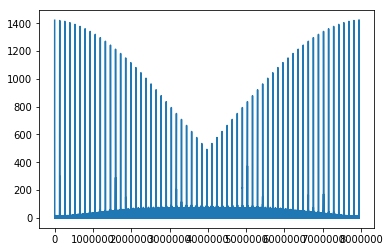

In [93]:
# label is 0 - case 2

fileID = '29962f9102502ee76bb3cddb8cf8c9ad'
customerID = '597df153a25e8e548cbe35f6e4da9cbb'
productID = 'c105a0'
output = time_list(fileID, customerID, productID, df_query_log)

plt.plot(abs(fft(output)))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

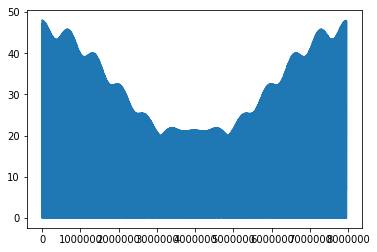

In [85]:
# label is 1 - case 1

fileID = '0005e4c0263f52453438ddd0d55aef82'
customerID = 'acbc75a1133d045877136fde7be7222b'
productID = '7acab3'
output = time_list(fileID, customerID, productID, df_query_log)

plt.plot(abs(fft(output)))

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

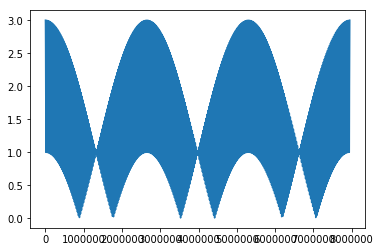

In [95]:
# label is 1 - case 2

fileID = '00117b31bd107c43123c8a0180dc036c'
customerID = '0f20dc11f6009e3855301c94af0467ea'
productID = 'c76d58'
output = time_list(fileID, customerID, productID, df_query_log)

plt.plot(abs(fft(output)))

# Appendix

### 1. get spicifit index values

In [12]:
df.loc[df_query_log['FileID']=='dfccd8e23f0b03ec4db7a9a745ad7399'].index.values

array([   0,    5,   23,   37,   39,   43,   50,   53,   62,   65,   68,
         70,   73,   75,   77,   82,   83,   87,   90,   93,   97,   99,
        100,  103,  107,  110,  116,  126,  129,  133,  137,  140,  143,
        146,  148,  152,  154,  156,  159,  162,  167,  169,  173,  175,
        177,  181,  182,  185,  191,  196,  200,  205,  210,  213,  217,
        220,  222,  224,  225,  229,  235,  241,  247,  249,  253,  256,
        261,  267,  271,  273,  276,  280,  286,  288,  291,  293,  296,
        298,  303,  307,  313,  317,  324,  327,  333,  338,  343,  348,
        352,  355,  360,  362,  370,  373,  382,  386,  392,  395,  401,
        408,  413,  416,  419,  420,  423,  427,  431,  437,  443,  448,
        452,  456,  462,  466,  472,  475,  478,  480,  481,  484,  488,
        493,  496,  498,  502,  504,  510,  513,  519,  520,  522,  525,
        529,  531,  534,  539,  542,  545,  549,  555,  559,  561,  565,
        569,  573,  576,  579,  583,  586,  590,  5

df.loc[]
df[]